In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import torch.nn as tnn
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [3]:
# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [4]:
data = pd.read_csv('../data/gata1_remap.tsv.gz', sep=',')
data.columns = ['id', 'loc', 'seq', 'target']
misreads = []
for index, seq in enumerate(data['seq']):
    if seq.replace('A', '').replace('C', '').replace('G', '').replace('T', '') is not '':
        misreads.append(index)
data = data.drop(misreads)
data.index = range(len(data))

train_10000_dataframe = data.sample(n=10000)
train_1000_dataframe = train_10000_dataframe.sample(n=1000)
train_100_dataframe = train_1000_dataframe.sample(n=100)
train_10_dataframe = train_100_dataframe.sample(n=10)
train_4_dataframe = train_10_dataframe.sample(n=4)
train_1_dataframe = train_4_dataframe.sample(n=1)

train_1_dataframe.index = range(1)
train_4_dataframe.index = range(4)
train_10_dataframe.index = range(10)
train_100_dataframe.index = range(100)
train_1000_dataframe.index = range(1000)
train_10000_dataframe.index = range(10000)

# train_data = mb.tl.ChipSeqDataset(data_frame=data)
# train_loader = tdata.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
train_1_data = mb.tl.ChipSeqDataset(data_frame=train_1_dataframe)
train_1_loader = tdata.DataLoader(dataset=train_1_data, batch_size=1, shuffle=False)
train_4_data = mb.tl.ChipSeqDataset(data_frame=train_4_dataframe)
train_4_loader = tdata.DataLoader(dataset=train_4_data, batch_size=4, shuffle=False)
train_10_data = mb.tl.ChipSeqDataset(data_frame=train_10_dataframe)
train_10_loader = tdata.DataLoader(dataset=train_10_data, batch_size=10, shuffle=False)
train_100_data = mb.tl.ChipSeqDataset(data_frame=train_100_dataframe)
train_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=10, shuffle=True)
test_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=1, shuffle=False)
train_1000_data = mb.tl.ChipSeqDataset(data_frame=train_1000_dataframe)
train_1000_loader = tdata.DataLoader(dataset=train_1000_data, batch_size=64, shuffle=True)
test_1000_loader = tdata.DataLoader(dataset=train_1000_data, batch_size=1, shuffle=False)
train_10000_data = mb.tl.ChipSeqDataset(data_frame=train_10000_dataframe)
train_10000_loader = tdata.DataLoader(dataset=train_10000_data, batch_size=256, shuffle=True)
test_10000_loader = tdata.DataLoader(dataset=train_10000_data, batch_size=1, shuffle=False)

In [5]:
# Large conv. layer, linear layer with clipping
net = mb.tl.Network_PB().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001)
criterion = tnn.BCELoss()
loss_history = []

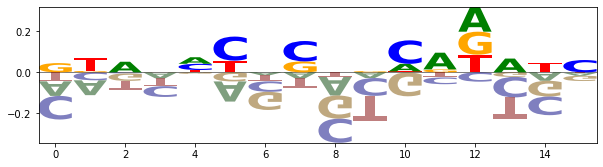

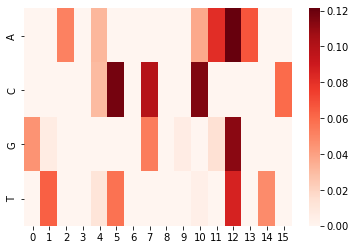

In [6]:
# for both scaling-weights, the log-value is saved s.t. the final scaling is positive. 
# For the first one it doesn't seem to change much, but for the second one posivity is necessary
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))  # weight before the exp. fct.
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))  # weight after the exp. fct.
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

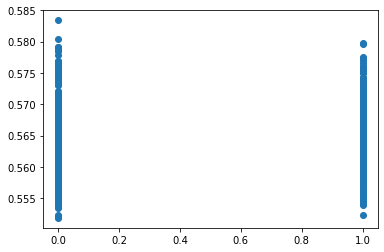

In [7]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.56316537
0.5641736


<AxesSubplot:>

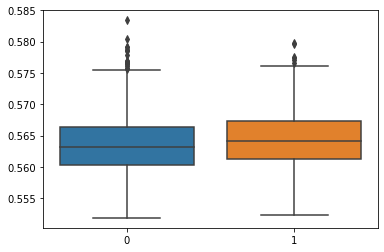

In [8]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [21]:
# optimiser = topti.Adam(net.parameters(), lr=0.00001)
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.381
Epoch:  2, Loss: 0.380
Epoch:  3, Loss: 0.380
Epoch:  4, Loss: 0.382
Epoch:  5, Loss: 0.379
Epoch:  6, Loss: 0.380
Epoch:  7, Loss: 0.378
Epoch:  8, Loss: 0.379
Epoch:  9, Loss: 0.374
Epoch: 10, Loss: 0.376
Epoch: 11, Loss: 0.375
Epoch: 12, Loss: 0.376
Epoch: 13, Loss: 0.376
Epoch: 14, Loss: 0.377
Epoch: 15, Loss: 0.378
Epoch: 16, Loss: 0.376
Epoch: 17, Loss: 0.381
Epoch: 18, Loss: 0.380
Epoch: 19, Loss: 0.380
Epoch: 20, Loss: 0.377
Epoch: 21, Loss: 0.377
Epoch: 22, Loss: 0.379
Epoch: 23, Loss: 0.375
Epoch: 24, Loss: 0.381
Epoch: 25, Loss: 0.377
Epoch: 26, Loss: 0.374
Epoch: 27, Loss: 0.374
Epoch: 28, Loss: 0.377
Epoch: 29, Loss: 0.376
Epoch: 30, Loss: 0.378
Epoch: 31, Loss: 0.376
Epoch: 32, Loss: 0.375
Epoch: 33, Loss: 0.376
Epoch: 34, Loss: 0.376
Epoch: 35, Loss: 0.381
Epoch: 36, Loss: 0.377
Epoch: 37, Loss: 0.377
Epoch: 38, Loss: 0.379
Epoch: 39, Loss: 0.377
Epoch: 40, Loss: 0.380
Epoch: 41, Loss: 0.383
Epoch: 42, Loss: 0.382
Epoch: 43, Loss: 0.378
Epoch: 44, 

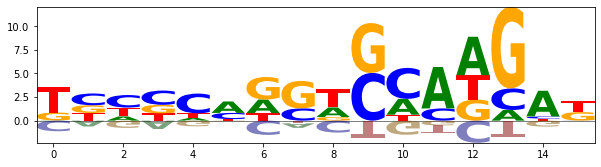

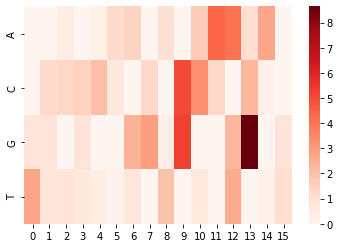

In [22]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

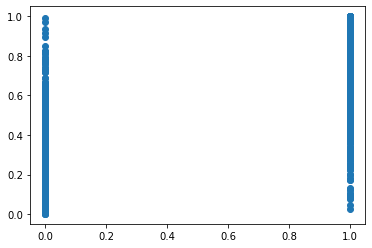

In [23]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.18979181
0.82465774


<AxesSubplot:>

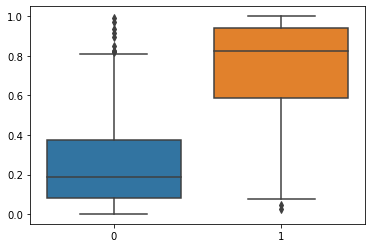

In [24]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

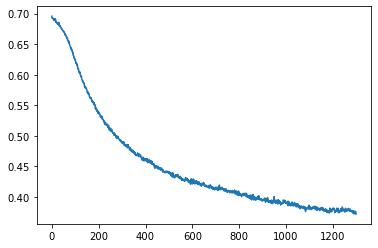

In [25]:
loss_history = np.array(loss_history)
plt.plot(loss_history)

-----------------------------

Model with a conv layer of length 8, one positive scaling parameter, x/(1+x) output, with regularization

In [4]:
data = pd.read_csv('../data/gata1_remap.tsv.gz', sep=',')
data.columns = ['id', 'loc', 'seq', 'target']
misreads = []
for index, seq in enumerate(data['seq']):
    if seq.replace('A', '').replace('C', '').replace('G', '').replace('T', '') is not '':
        misreads.append(index)
data = data.drop(misreads)
data.index = range(len(data))

test_dataframe = data.sample(frac=0.01)
train_dataframe = data.drop(test_dataframe.index)

test_dataframe.index = range(len(test_dataframe))
train_dataframe.index = range(len(train_dataframe))

train_data = mb.tl.ChipSeqDataset(data_frame=train_dataframe)
train_loader = tdata.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_data = mb.tl.ChipSeqDataset(data_frame=test_dataframe)
test_loader = tdata.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [5]:
net = mb.tl.Network_PB().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
criterion = tnn.BCELoss()
loss_history = []

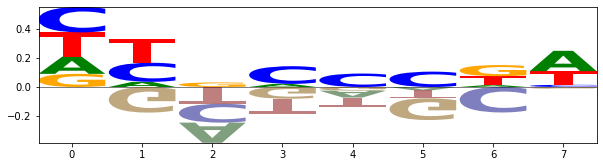

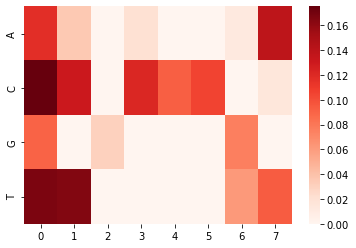

In [6]:
# for both scaling-weights, the log-value is saved s.t. the final scaling is positive. 
# For the first one it doesn't seem to change much, but for the second one posivity is necessary
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))  # weight before the exp. fct.
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))  # weight after the exp. fct.
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

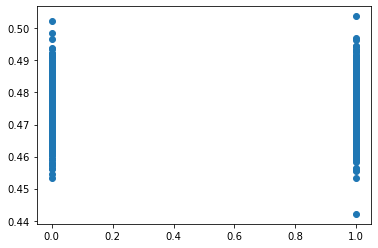

In [7]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.47348857
0.47287372


<AxesSubplot:>

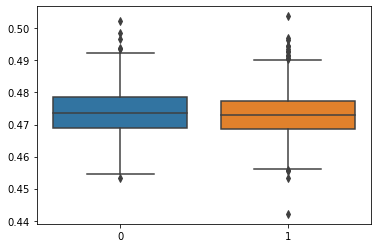

In [8]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [22]:
# optimiser = topti.Adam(net.parameters(), lr=0.0001)
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.553
Epoch:  2, Loss: 0.554
Epoch:  3, Loss: 0.556
Epoch:  4, Loss: 0.553
Epoch:  5, Loss: 0.554
Epoch:  6, Loss: 0.555
Epoch:  7, Loss: 0.555
Epoch:  8, Loss: 0.554
Epoch:  9, Loss: 0.554
Epoch: 10, Loss: 0.554
Epoch: 11, Loss: 0.554
Epoch: 12, Loss: 0.554
Epoch: 13, Loss: 0.555
Epoch: 14, Loss: 0.554
Epoch: 15, Loss: 0.556
Epoch: 16, Loss: 0.556
Epoch: 17, Loss: 0.554
Epoch: 18, Loss: 0.557
Epoch: 19, Loss: 0.553
Epoch: 20, Loss: 0.555
Epoch: 21, Loss: 0.557
Epoch: 22, Loss: 0.555
Epoch: 23, Loss: 0.556
Epoch: 24, Loss: 0.553
Epoch: 25, Loss: 0.555
Epoch: 26, Loss: 0.555
Epoch: 27, Loss: 0.556
Epoch: 28, Loss: 0.554
Epoch: 29, Loss: 0.553
Epoch: 30, Loss: 0.557
Epoch: 31, Loss: 0.552
Epoch: 32, Loss: 0.554
Epoch: 33, Loss: 0.554
Epoch: 34, Loss: 0.556
Epoch: 35, Loss: 0.554
Epoch: 36, Loss: 0.553
Epoch: 37, Loss: 0.552
Epoch: 38, Loss: 0.555
Epoch: 39, Loss: 0.555
Epoch: 40, Loss: 0.554
Epoch: 41, Loss: 0.556
Epoch: 42, Loss: 0.554
Epoch: 43, Loss: 0.555
Epoch: 44, 

0.004359811


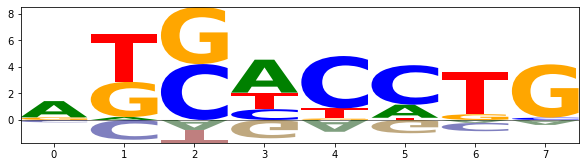

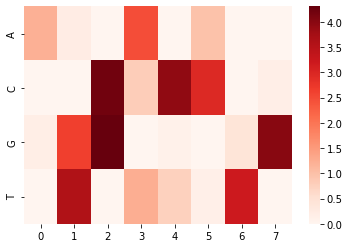

In [23]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

<AxesSubplot:>

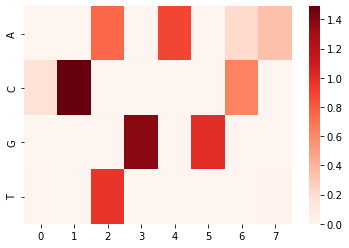

In [24]:
# create a heatmap of the negative weights
weights = -net.conv.weight.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
sns.heatmap(weights, cmap='Reds', vmin=0)

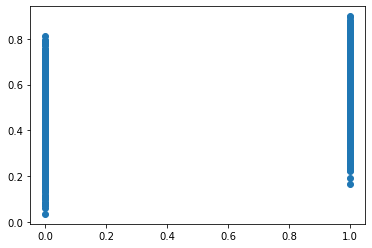

In [25]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.36373988
0.6109689


<AxesSubplot:>

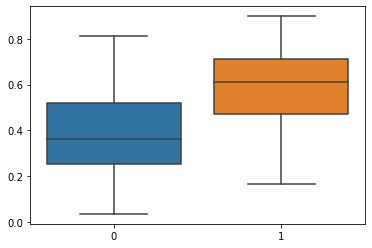

In [26]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

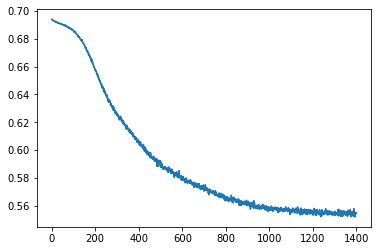

In [27]:
loss_history = np.array(loss_history)
plt.plot(loss_history)

In [28]:
net.normalize_weights()
loss_history = []

0.004359811


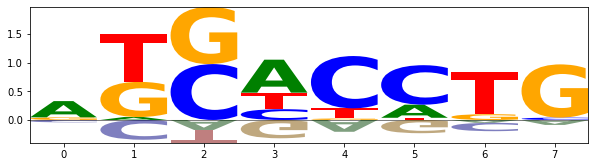

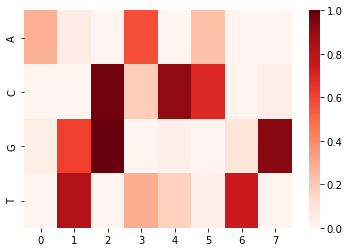

In [29]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

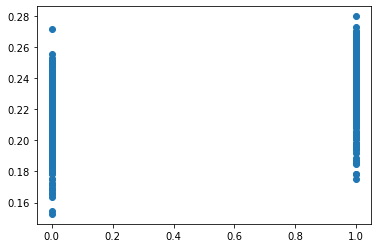

In [30]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.21502545
0.23691191


<AxesSubplot:>

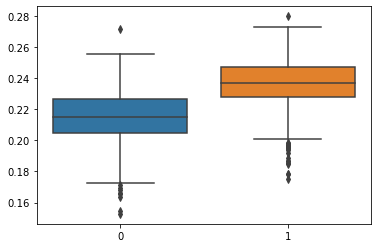

In [31]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [36]:
# optimiser = topti.Adam(net.parameters(), lr=0.0001)
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.665
Epoch:  2, Loss: 0.665
Epoch:  3, Loss: 0.665
Epoch:  4, Loss: 0.665
Epoch:  5, Loss: 0.665
Epoch:  6, Loss: 0.665
Epoch:  7, Loss: 0.665
Epoch:  8, Loss: 0.665
Epoch:  9, Loss: 0.665
Epoch: 10, Loss: 0.665
Epoch: 11, Loss: 0.665
Epoch: 12, Loss: 0.665
Epoch: 13, Loss: 0.665
Epoch: 14, Loss: 0.665
Epoch: 15, Loss: 0.665
Epoch: 16, Loss: 0.665
Epoch: 17, Loss: 0.665
Epoch: 18, Loss: 0.665
Epoch: 19, Loss: 0.665
Epoch: 20, Loss: 0.665
Epoch: 21, Loss: 0.665
Epoch: 22, Loss: 0.665
Epoch: 23, Loss: 0.665
Epoch: 24, Loss: 0.665
Epoch: 25, Loss: 0.665
Epoch: 26, Loss: 0.665
Epoch: 27, Loss: 0.665
Epoch: 28, Loss: 0.665
Epoch: 29, Loss: 0.665
Epoch: 30, Loss: 0.665
Epoch: 31, Loss: 0.665
Epoch: 32, Loss: 0.665
Epoch: 33, Loss: 0.665
Epoch: 34, Loss: 0.665
Epoch: 35, Loss: 0.665
Epoch: 36, Loss: 0.665
Epoch: 37, Loss: 0.665
Epoch: 38, Loss: 0.665
Epoch: 39, Loss: 0.665
Epoch: 40, Loss: 0.665
Epoch: 41, Loss: 0.665
Epoch: 42, Loss: 0.665
Epoch: 43, Loss: 0.665
Epoch: 44, 

0.014436059


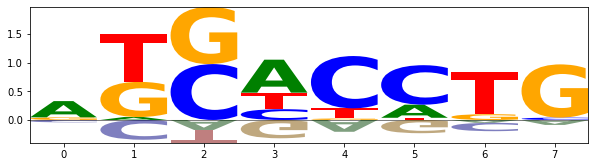

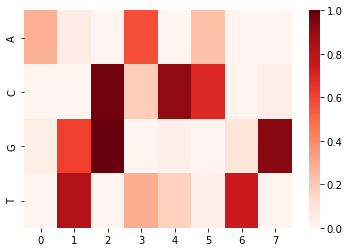

In [37]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

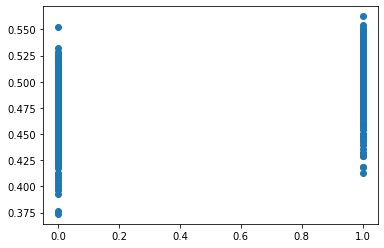

In [38]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.47562072
0.5069034


<AxesSubplot:>

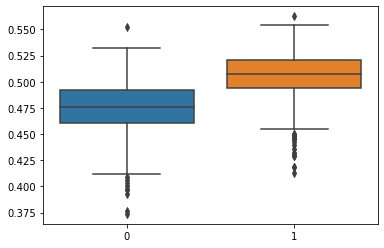

In [39]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [51]:
# optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.553
Epoch:  2, Loss: 0.556
Epoch:  3, Loss: 0.554
Epoch:  4, Loss: 0.555
Epoch:  5, Loss: 0.556
Epoch:  6, Loss: 0.554
Epoch:  7, Loss: 0.552
Epoch:  8, Loss: 0.555
Epoch:  9, Loss: 0.554
Epoch: 10, Loss: 0.555
Epoch: 11, Loss: 0.556
Epoch: 12, Loss: 0.554
Epoch: 13, Loss: 0.553
Epoch: 14, Loss: 0.555
Epoch: 15, Loss: 0.554
Epoch: 16, Loss: 0.554
Epoch: 17, Loss: 0.555
Epoch: 18, Loss: 0.557
Epoch: 19, Loss: 0.555
Epoch: 20, Loss: 0.554
Epoch: 21, Loss: 0.552
Epoch: 22, Loss: 0.556
Epoch: 23, Loss: 0.552
Epoch: 24, Loss: 0.552
Epoch: 25, Loss: 0.554
Epoch: 26, Loss: 0.553
Epoch: 27, Loss: 0.553
Epoch: 28, Loss: 0.555
Epoch: 29, Loss: 0.554
Epoch: 30, Loss: 0.555
Epoch: 31, Loss: 0.556
Epoch: 32, Loss: 0.554
Epoch: 33, Loss: 0.554
Epoch: 34, Loss: 0.554
Epoch: 35, Loss: 0.556
Epoch: 36, Loss: 0.554
Epoch: 37, Loss: 0.553
Epoch: 38, Loss: 0.555
Epoch: 39, Loss: 0.555
Epoch: 40, Loss: 0.554
Epoch: 41, Loss: 0.555
Epoch: 42, Loss: 0.554
Epoch: 43, Loss: 0.555
Epoch: 44, 

0.012606366


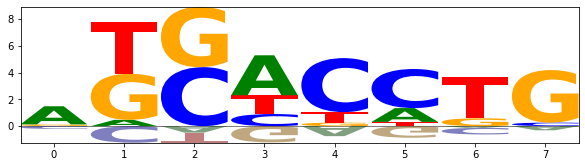

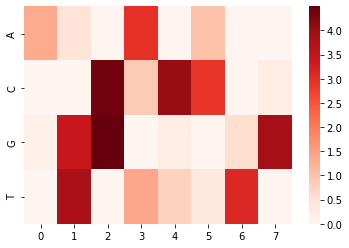

In [52]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

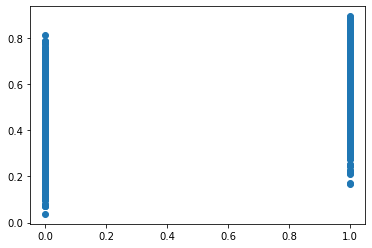

In [53]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.36104736
0.60750085


<AxesSubplot:>

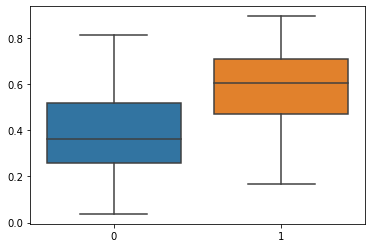

In [54]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [55]:
net.normalize_weights()
loss_history = []

0.012606366


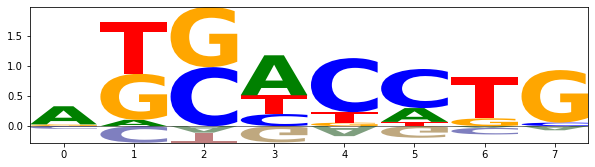

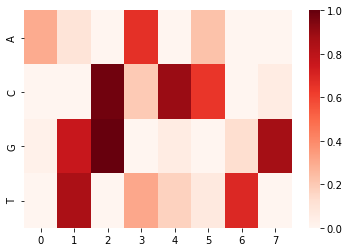

In [56]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

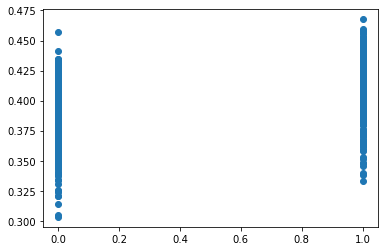

In [57]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.39013228
0.4173293


<AxesSubplot:>

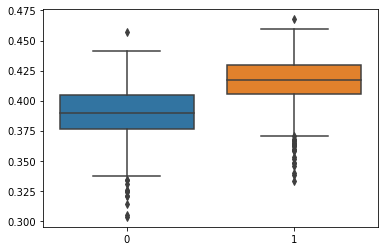

In [58]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [67]:
# optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.554
Epoch:  2, Loss: 0.552
Epoch:  3, Loss: 0.552
Epoch:  4, Loss: 0.553
Epoch:  5, Loss: 0.556
Epoch:  6, Loss: 0.553
Epoch:  7, Loss: 0.555
Epoch:  8, Loss: 0.552
Epoch:  9, Loss: 0.553
Epoch: 10, Loss: 0.552
Epoch: 11, Loss: 0.555
Epoch: 12, Loss: 0.554
Epoch: 13, Loss: 0.555
Epoch: 14, Loss: 0.553
Epoch: 15, Loss: 0.555
Epoch: 16, Loss: 0.555
Epoch: 17, Loss: 0.554
Epoch: 18, Loss: 0.554
Epoch: 19, Loss: 0.554
Epoch: 20, Loss: 0.553
Epoch: 21, Loss: 0.555
Epoch: 22, Loss: 0.554
Epoch: 23, Loss: 0.554
Epoch: 24, Loss: 0.553
Epoch: 25, Loss: 0.554
Epoch: 26, Loss: 0.554
Epoch: 27, Loss: 0.554
Epoch: 28, Loss: 0.555
Epoch: 29, Loss: 0.556
Epoch: 30, Loss: 0.555
Epoch: 31, Loss: 0.557
Epoch: 32, Loss: 0.554
Epoch: 33, Loss: 0.556
Epoch: 34, Loss: 0.556
Epoch: 35, Loss: 0.555
Epoch: 36, Loss: 0.556
Epoch: 37, Loss: 0.554
Epoch: 38, Loss: 0.553
Epoch: 39, Loss: 0.553
Epoch: 40, Loss: 0.554
Epoch: 41, Loss: 0.554
Epoch: 42, Loss: 0.554
Epoch: 43, Loss: 0.555
Epoch: 44, 

0.011616825


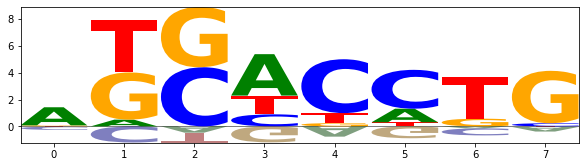

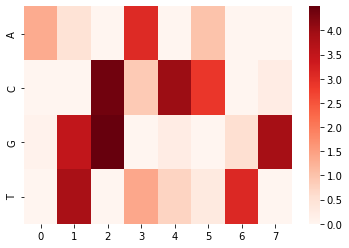

In [68]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

<AxesSubplot:>

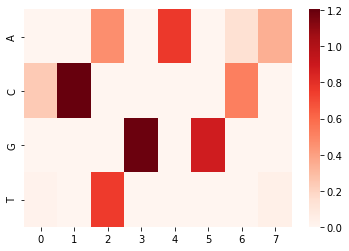

In [69]:
# create a heatmap of the negative weights
weights = -net.conv.weight.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
sns.heatmap(weights, cmap='Reds', vmin=0)

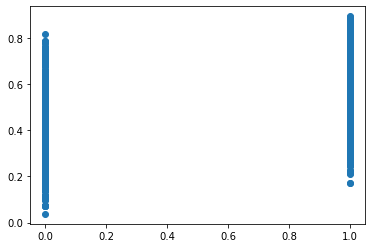

In [70]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.36078474
0.60634226


<AxesSubplot:>

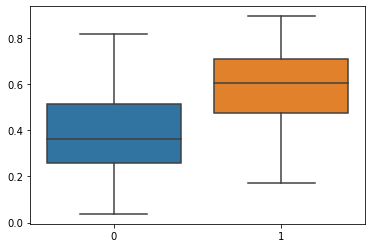

In [71]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

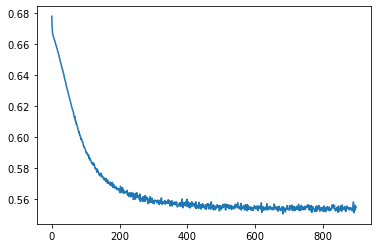

In [72]:
loss_history = np.array(loss_history)
plt.plot(loss_history)

----

Same config, full training set

In [4]:
data = pd.read_csv('../data/gata1_remap.tsv.gz', sep=',')
data.columns = ['id', 'loc', 'seq', 'target']
misreads = []
for index, seq in enumerate(data['seq']):
    if seq.replace('A', '').replace('C', '').replace('G', '').replace('T', '') is not '':
        misreads.append(index)
data = data.drop(misreads)
data.index = range(len(data))

test_dataframe = data.sample(frac=0.01)
train_dataframe = data.drop(test_dataframe.index)

test_dataframe.index = range(len(test_dataframe))
train_dataframe.index = range(len(train_dataframe))

train_data = mb.tl.ChipSeqDataset(data_frame=train_dataframe, use_dinuc=False)
train_loader = tdata.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_data = mb.tl.ChipSeqDataset(data_frame=test_dataframe, use_dinuc=False)
test_loader = tdata.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [74]:
net = mb.tl.Network_PB().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
criterion = tnn.BCELoss()
loss_history = []

0.004991593


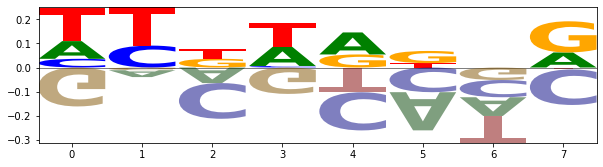

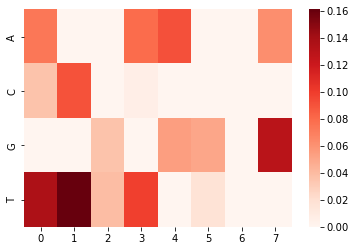

In [75]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

In [76]:
# optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
net.train()
loss_history += mb.tl.train_network(net, train_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.682
Epoch:  2, Loss: 0.602
Epoch:  3, Loss: 0.580
Epoch:  4, Loss: 0.577
Epoch:  5, Loss: 0.575
Epoch:  6, Loss: 0.574
Epoch:  7, Loss: 0.573
Epoch:  8, Loss: 0.572
Epoch:  9, Loss: 0.571
Epoch: 10, Loss: 0.570
Epoch: 11, Loss: 0.570
Epoch: 12, Loss: 0.570
Epoch: 13, Loss: 0.569
Epoch: 14, Loss: 0.569
Epoch: 15, Loss: 0.569
Epoch: 16, Loss: 0.569
Epoch: 17, Loss: 0.569
Epoch: 18, Loss: 0.569
Epoch: 19, Loss: 0.569
Epoch: 20, Loss: 0.569
Epoch: 21, Loss: 0.569
Epoch: 22, Loss: 0.569
Epoch: 23, Loss: 0.569
Epoch: 24, Loss: 0.569
Epoch: 25, Loss: 0.569
Epoch: 26, Loss: 0.569
Epoch: 27, Loss: 0.569
Epoch: 28, Loss: 0.569
Epoch: 29, Loss: 0.569
Epoch: 30, Loss: 0.569
Epoch: 31, Loss: 0.569
Epoch: 32, Loss: 0.569
Epoch: 33, Loss: 0.569
Epoch: 34, Loss: 0.569
Epoch: 35, Loss: 0.569
Epoch: 36, Loss: 0.569
Epoch: 37, Loss: 0.569
Epoch: 38, Loss: 0.569
Epoch: 39, Loss: 0.569
Epoch: 40, Loss: 0.569
Epoch: 41, Loss: 0.569
Epoch: 42, Loss: 0.569
Epoch: 43, Loss: 0.569
Epoch: 44, 

0.010955255


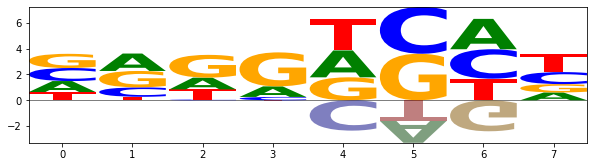

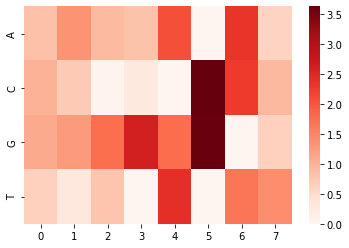

In [77]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

<AxesSubplot:>

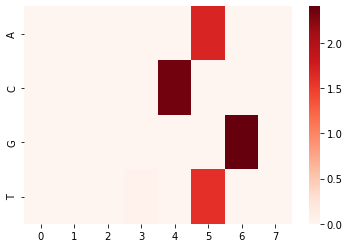

In [78]:
# create a heatmap of the negative weights
weights = -net.conv.weight.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
sns.heatmap(weights, cmap='Reds', vmin=0)

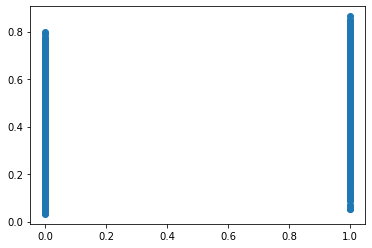

In [79]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.4209134
0.6032951


<AxesSubplot:>

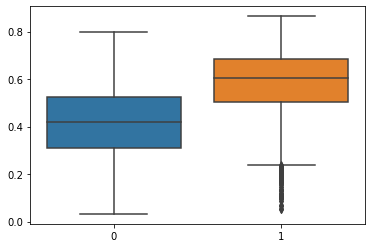

In [80]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

Same analysis again

In [13]:
net = mb.tl.Network_PB().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
criterion = tnn.BCELoss()
loss_history = []

0.004991593


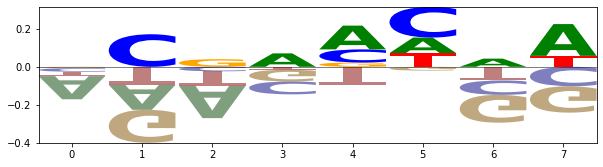

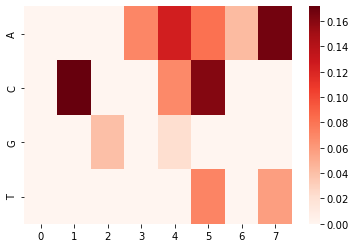

In [14]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

In [15]:
# optimiser = topti.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
net.train()
loss_history += mb.tl.train_network(net, train_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.674
Epoch:  2, Loss: 0.591
Epoch:  3, Loss: 0.576
Epoch:  4, Loss: 0.573
Epoch:  5, Loss: 0.572
Epoch:  6, Loss: 0.571
Epoch:  7, Loss: 0.571
Epoch:  8, Loss: 0.571
Epoch:  9, Loss: 0.571
Epoch: 10, Loss: 0.571
Epoch: 11, Loss: 0.571
Epoch: 12, Loss: 0.571
Epoch: 13, Loss: 0.571
Epoch: 14, Loss: 0.571
Epoch: 15, Loss: 0.571
Epoch: 16, Loss: 0.571
Epoch: 17, Loss: 0.571
Epoch: 18, Loss: 0.571
Epoch: 19, Loss: 0.571
Epoch: 20, Loss: 0.571
Epoch: 21, Loss: 0.571
Epoch: 22, Loss: 0.571
Epoch: 23, Loss: 0.571
Epoch: 24, Loss: 0.571
Epoch: 25, Loss: 0.571
Epoch: 26, Loss: 0.571
Epoch: 27, Loss: 0.571
Epoch: 28, Loss: 0.571
Epoch: 29, Loss: 0.571
Epoch: 30, Loss: 0.571
Epoch: 31, Loss: 0.571
Epoch: 32, Loss: 0.571
Epoch: 33, Loss: 0.571
Epoch: 34, Loss: 0.571
Epoch: 35, Loss: 0.571
Epoch: 36, Loss: 0.571
Epoch: 37, Loss: 0.571
Epoch: 38, Loss: 0.571
Epoch: 39, Loss: 0.571
Epoch: 40, Loss: 0.571
Epoch: 41, Loss: 0.571
Epoch: 42, Loss: 0.571
Epoch: 43, Loss: 0.571
Epoch: 44, 

0.011135752


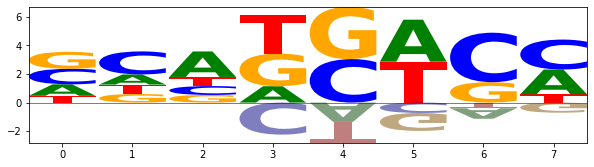

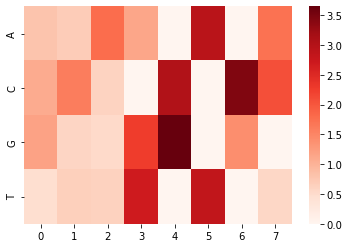

In [16]:
# print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

<AxesSubplot:>

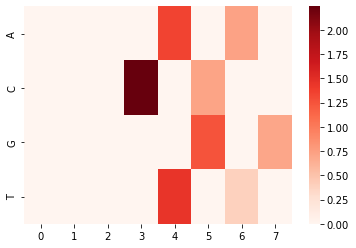

In [17]:
# create a heatmap of the negative weights
weights = -net.conv.weight.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
sns.heatmap(weights, cmap='Reds', vmin=0)

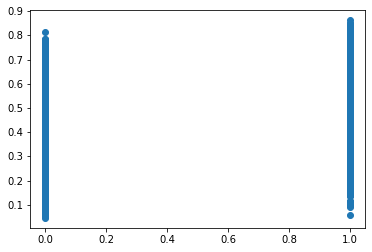

In [19]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["mononuc"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.40029722
0.5976091


<AxesSubplot:>

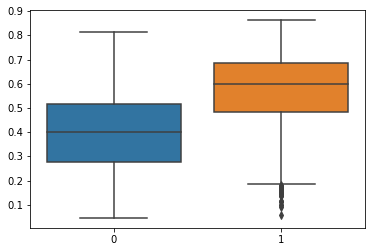

In [20]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

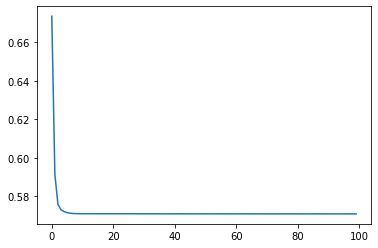

In [21]:
loss_history = np.array(loss_history)
plt.plot(loss_history)